<a href="https://colab.research.google.com/github/NicolaGabriele/powerline_Segmentation_project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IMPORT DELLE LIBRERIE E CARICAMENTO DEL DATASET**


In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import random
from pycocotools import mask
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
TRAIN_DIR = '/content/drive/MyDrive/trainingset' #'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\trainingset'#
TEST_DIR = '/content/drive/MyDrive/testset' #'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\testset'#
TRAIN_LABELS = '/content/drive/MyDrive/train.json' #'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\train.json'#
TEST_LABELS =  '/content/drive/MyDrive/test.json' #'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\test.json'
IM_WIDTH = 700
IM_HEIGHT = 700

In [3]:
def groupByImageId(jsonfile):
  data = jsonfile['annotations']
  labs = {}
  for k in data:
    if k['image_id'] in labs:
      labs[k['image_id']].append(k)
    else:
      labs[k['image_id']] = [k]
  return labs

In [4]:
class PowerLineDataset(torch.utils.data.Dataset):
  def __init__(self,img_dir,img_labels):
    self.img_dir = img_dir
    self.img_labels = json.load(open(img_labels))
    self.categories = [] #lista delle etichette di classe
    for c in self.img_labels['categories']:
      self.categories.append(c['name'])

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir, self.img_labels['images'][idx]['file_name'])
    label = groupByImageId(self.img_labels)[idx]
    image = (torchvision.io.read_image(img_path)/255)
    return image,label
  def __len__(self):
    return len(os.listdir(self.img_dir))

In [5]:
#caricamento dei dataset di train e di test
trainset = PowerLineDataset(TRAIN_DIR, TRAIN_LABELS)
test = PowerLineDataset(TEST_DIR, TEST_LABELS)

#**OPERAZIONI SUI DATI: DATA AUGMENTATION**

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self, in_channels=3):
    super(AutoEncoder,self).__init__()
    self.encoder = nn.Sequential(
         nn.Conv2d(in_channels, 64, kernel_size=3, padding = 1),
         nn.ReLU(),
         nn.Conv2d(64, 128, kernel_size=3, padding = 1),
         nn.ReLU(),
         nn.Conv2d(128, 256, kernel_size=3, padding = 1),
         nn.ReLU(),
         nn.MaxPool2d(2,stride = 2,return_indices=False))
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(256, 128, kernel_size=3, stride = 2, padding = 1, output_padding = 1),
        nn.ReLU(),
        nn.Conv2d(128, 64, kernel_size=3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(64, in_channels, kernel_size=3, padding = 1),
        nn.ReLU())

  def forward(self,x):
    #x.to('cuda')
    x = self.encoder(x)
    x = self.decoder(x)
    return x



In [ ]:
model = AutoEncoder()
#model.to('cuda')

In [ ]:
#questo metodo è preso dai notebook e va adattato al caso specifico (loss ecc...)
#costruisco un sottodataset di 200 immagini
#indexs = list(range(0,200))
#trains = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset,indexs), batch_size=64, shuffle=True)
trains = torch.utils.data.DataLoader(trainset)
criterion = torch.nn.MSELoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_step = len(trains)
batch_size = 64

num_epochs = 1

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trains) for i in range(num_epochs + 1)]


def train(epoch,model,criterion,optimizer,reshape=False):
    for batch_idx, (images, labels) in enumerate(trains):
        # Move tensors to the configured device
        #if reshape:
         #   images = images.reshape(-1, 28*28)
        #images = images.to('cuda')
        #labels = labels.to('cuda')
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if random.random() < 0.1:
          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, num_epochs, batch_idx+1, total_step, loss.item()))
        if (batch_idx+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, num_epochs, batch_idx+1, total_step, loss.item()))

        train_losses.append(loss.item())
        train_counter.append(
        (batch_idx*batch_size) + ((epoch-1)*len(trains)))

In [ ]:
model = torch.load('/content/drive/MyDrive/autoencoder')
#train(num_epochs,model,criterion, optimizer, reshape=False)

In [ ]:
torch.save(model,'autoencoder')

#**LOSS FUNCTIONS**

In [6]:
def decodeSegmentationField(segmentation):
  return mask.decode(mask.merge(mask.frPyObjects(segmentation,IM_WIDTH,IM_HEIGHT)))

In [59]:
def formatLabels(labels):
  bbox = torch.zeros([len(labels),4], dtype=torch.float32)
  seg = []
  cls = []
  i = 0
  for label in labels:
    seg.append(decodeSegmentationField(label['segmentation']))
    b = label['bbox']
    box = [b[0],b[1],b[0]+b[2], b[1]+b[3]]
    bbox[i] = torch.Tensor(box)
    i+=1
    cls.append(label['category_id'])
  return {
      'id': label['id'],
      'masks':torch.Tensor(seg),
      'labels':torch.tensor(cls, dtype = torch.int64),
      'boxes':bbox
  }

In [8]:
class CustomLossFunction(nn.Module):
  def __init__(self, cls_loss, bb_loss, seg_loss, cls_weight, bb_weight, seg_weight):
    super(CustomLossFunction, self).__init__()
    self.cls_loss = cls_loss
    self.bb_loss = bb_loss
    self.seg_loss = seg_loss
    self.cls_weight = cls_weight
    self.bb_weight = bb_weight
    self.seg_weight = seg_weight
  def forward(self,predictions, targets):
    prediction = predictions[0]
    formatted_targets = formatLabels(targets)
    #loss di classificazione
    #scores di classificazione: uno per ogni oggetto predetto
    targets_cls = formatted_targets['labels']
    pred_cls = prediction['scores']
    loss_cls = self.cls_loss(pred_cls,targets_cls)
    #loss di bbox
    targets_bbox = formatted_targets['boxes']
    pred_bbox = prediction['boxes']
    loss_bbox = self.bb_loss(pred_bbox,targets_bbox)
    #loss per le maschere: sigmoide su tutti i pixel e poi cross entropy
    targets_masks = formatted_targets['masks']
    pred_masks = prediction['masks']
    loss_masks = self.seg_loss(pred_masks,targets_masks)

    return self.cls_weight*loss_cls + self.bb_weight*loss_bbox + self.seg_weight*loss_masks

#**TEST DI UN MODELLO PREADDESTRATO: MASK R-CNN**

In [45]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

In [11]:
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the numbner of output channels for the Mask Predictor
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=4)

# Replace the mask predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=4)

In [60]:
model.train()
x=torchvision.io.read_image('/content/drive/MyDrive/trainingset/06_5355.jpg')
predictions = model([trainset[3][0]], [formatLabels(trainset[3][1])])

In [61]:
predictions

{'loss_classifier': tensor(0.3442, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0514, grad_fn=<DivBackward0>),
 'loss_mask': tensor(0.6179, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_objectness': tensor(4.0472, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.1414, grad_fn=<DivBackward0>)}

In [48]:
model.eval()
im = torchvision.io.read_image('/content/cane.jpg')/255
prediction = model([im])
prediction

[{'boxes': tensor([[116.5476,  38.8285, 429.3652, 363.9462],
          [108.1883, 176.4281, 212.0991, 287.6004],
          [109.2908, 143.0172, 381.2148, 350.6211],
          [111.5342, 129.8146, 386.8564, 360.9250],
          [177.0055,  41.3692, 419.6705, 249.0362],
          [106.0233, 177.2468, 216.0398, 288.3090],
          [111.8797, 159.0416, 289.9033, 295.0478],
          [304.4940, 272.4727, 381.4745, 371.5638],
          [305.5607, 249.9626, 379.7747, 362.4712],
          [107.9577, 176.5410, 212.9287, 286.3120]], grad_fn=<StackBackward0>),
  'labels': tensor([18, 21, 20, 17, 18, 19, 18, 20, 17, 20]),
  'scores': tensor([0.9983, 0.4975, 0.0971, 0.0920, 0.0903, 0.0813, 0.0618, 0.0563, 0.0521,
          0.0510], grad_fn=<IndexBackward0>),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.

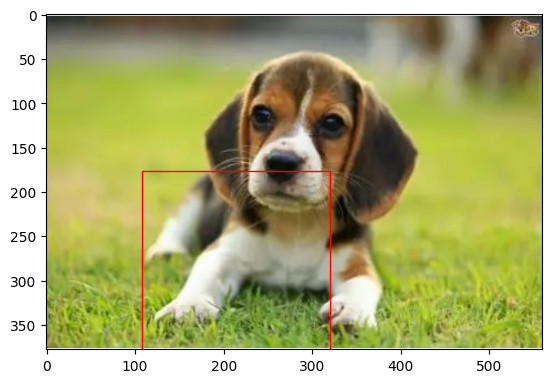

In [51]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = Image.open('/content/cane.jpg')

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)
#108.1883, 176.4281, 212.0991, 287.6004
# Create a Rectangle patch
rect = patches.Rectangle((108, 176), 212, 287, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [36]:
formatLabels(trainset[1][1])

{'id': 18,
 'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0.